This notebook illustrates how to apply the transformer metric to a single burst time series. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rasterio.plot import show
from scipy.special import expit, logit

from distmetrics import (
    compute_mahalonobis_dist_2d,
    compute_transformer_zscore,
    despeckle_rtc_arrs_with_tv,
    get_asf_rtc_burst_ts,
    load_transformer_model,
    read_asf_rtc_image_data,
)

References:

- CNN story: https://www.cnn.com/2024/05/25/world/video/damage-papua-new-guinea-landslide-ldn-digvid
- ASF Search: https://search.asf.alaska.edu/#/?polygon=POINT(143.3641%20-5.3821)&zoom=13.000&center=143.364,-5.425&resultsLoaded=true&granule=OPERA_L2_RTC-S1_T009-019294-IW2_20240603T084748Z_20240603T133726Z_S1A_30_v1.0&maxResults=250&dataset=OPERA-S1&productTypes=RTC

# Parameters

In [3]:
# Papau New Guinea Landslide
BURST_ID = "T009_019294_IW2"
EVENT_TS = pd.Timestamp("2024-05-28", tz="utc")

# Los Angeles Angeles Fire - Pacific Palisades Burst
BURST_ID = 'T071-151228-IW3'
EVENT_TS = pd.Timestamp("2025-01-08", tz="utc")

LOOKBACK_STRATEGY = 'multi_window'

N_PRE_IMAGES = 10
APPLY_LOGIT = True

N_PRE_IMGS_PER_YEAR = 3

# Download Data

In [4]:
df_rtc_ts = get_asf_rtc_burst_ts(BURST_ID)
print("# of results: ", df_rtc_ts.shape[0])
df_rtc_ts.head()

# of results:  108


,opera_id,acq_datetime,polarization,track_number,geometry,url_vh,url_vv,dedup_id
0,OPERA_L2_RTC-S1_T071-151228-IW3_20220101T13524...,2022-01-01 13:52:49+00:00,VV+VH,71,"POLYGON ((-118.23332 34.15997, -119.11344 34.2...",https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,OPERA_L2_RTC-S1_T071-151228-IW3_20220101T135249Z
1,OPERA_L2_RTC-S1_T071-151228-IW3_20220113T13524...,2022-01-13 13:52:49+00:00,VV+VH,71,"POLYGON ((-118.2332 34.15999, -119.11332 34.28...",https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,OPERA_L2_RTC-S1_T071-151228-IW3_20220113T135249Z
2,OPERA_L2_RTC-S1_T071-151228-IW3_20220125T13524...,2022-01-25 13:52:48+00:00,VV+VH,71,"POLYGON ((-118.23255 34.16051, -119.11264 34.2...",https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,OPERA_L2_RTC-S1_T071-151228-IW3_20220125T135248Z
3,OPERA_L2_RTC-S1_T071-151228-IW3_20220206T13524...,2022-02-06 13:52:48+00:00,VV+VH,71,"POLYGON ((-118.23289 34.15986, -119.11299 34.2...",https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,OPERA_L2_RTC-S1_T071-151228-IW3_20220206T135248Z
4,OPERA_L2_RTC-S1_T071-151228-IW3_20220218T13524...,2022-02-18 13:52:48+00:00,VV+VH,71,"POLYGON ((-118.23419 34.16046, -119.11426 34.2...",https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,OPERA_L2_RTC-S1_T071-151228-IW3_20220218T135248Z


In [5]:
def get_anniversary_indices(timestamps: list[pd.Timestamp], event_time: pd.Timestamp, n_imgs_per_year=N_PRE_IMGS_PER_YEAR) -> list[int]:
    ts_series = pd.Series(timestamps)
    base_anniv = event_time - pd.Timedelta(days=365)
    years = sorted(set(ts.year for ts in timestamps if ts.year < event_time.year))
    result = []

    for y in years:
        anniv = base_anniv.replace(year=y)
        candidates = ts_series[ts_series < anniv]
        if not candidates.empty:
            closest = (candidates - anniv).abs().nsmallest(n_imgs_per_year)
            result.extend(closest.index.tolist())

    return sorted(result)

# Determine which images we need to load (pre/post filtering)
acq_dts = df_rtc_ts.acq_datetime.tolist()
post_index = [k for (k, date) in enumerate(acq_dts) if date >= EVENT_TS][0]
post_date = acq_dts[post_index]
post_date

Timestamp('2025-01-09 13:52:54+0000', tz='UTC')

In [6]:
if LOOKBACK_STRATEGY == 'immediate':
    pre_indices = [k for (k, date) in enumerate(acq_dts) if date < EVENT_TS][-N_PRE_IMAGES:]
elif LOOKBACK_STRATEGY == 'multi_window':
    pre_indices = get_anniversary_indices(acq_dts, post_date)
else:
    raise NotImplementedError('needs to be immediate or multi_window')
pre_dates = [acq_dts[k] for k in pre_indices]
pre_dates
    

[Timestamp('2022-01-01 13:52:49+0000', tz='UTC'),
 Timestamp('2022-12-15 13:52:56+0000', tz='UTC'),
 Timestamp('2022-12-27 13:52:55+0000', tz='UTC'),
 Timestamp('2023-01-08 13:52:55+0000', tz='UTC'),
 Timestamp('2023-12-10 13:53:01+0000', tz='UTC'),
 Timestamp('2023-12-22 13:53:00+0000', tz='UTC'),
 Timestamp('2024-01-03 13:53:00+0000', tz='UTC')]

In [8]:
# Combine all indices we need to load
indices_to_load = sorted(pre_indices + [post_index])
print(f"Loading {len(indices_to_load)} images out of {len(df_rtc_ts)} total images")
print(f"Pre-event indices: {pre_indices}")
print(f"Post-event index: {post_index}")

# Create filtered dataframe and URL lists for only the images we need
df_rtc_filtered = df_rtc_ts.iloc[indices_to_load].copy()
urls_vv_filtered = df_rtc_filtered.url_vv.tolist()
urls_vh_filtered = df_rtc_filtered.url_vh.tolist()

Loading 8 images out of 108 total images
Pre-event indices: [0, 29, 30, 31, 59, 60, 61]
Post-event index: 92


**Warning**: sometime this cell fails and must be re-run due to a transient server error.

In [10]:
# Load only the filtered images (much more memory efficient!)
arrs_vv, profiles = read_asf_rtc_image_data(urls_vv_filtered)
arrs_vh, _ = read_asf_rtc_image_data(urls_vh_filtered)

Loading RTC data: 100%|█| 8/8 [00:08<00:00,  1
Loading RTC data: 100%|█| 8/8 [00:08<00:00,  1


In [11]:
arrs_vv_d = despeckle_rtc_arrs_with_tv(arrs_vv, n_jobs=10, interp_method='bilinear')
arrs_vh_d = despeckle_rtc_arrs_with_tv(arrs_vh, n_jobs=10, interp_method='bilinear')

Despeckling: 100%|█| 8/8 [00:06<00:00,  1.16it
Despeckling: 100%|█| 8/8 [00:06<00:00,  1.15it


In [12]:
# Create mapping from original indices to filtered array indices
original_to_filtered = {orig_idx: filtered_idx for filtered_idx, orig_idx in enumerate(indices_to_load)}
pre_indices_filtered = [original_to_filtered[idx] for idx in pre_indices]
post_index_filtered = original_to_filtered[post_index]

print(f"Original pre-indices: {pre_indices}")
print(f"Filtered pre-indices: {pre_indices_filtered}")
print(f"Original post-index: {post_index}")
print(f"Filtered post-index: {post_index_filtered}")


Original pre-indices: [0, 29, 30, 31, 59, 60, 61]
Filtered pre-indices: [0, 1, 2, 3, 4, 5, 6]
Original post-index: 92
Filtered post-index: 7


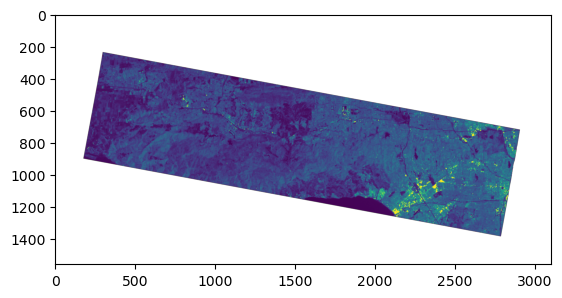

In [13]:
plt.imshow(arrs_vh_d[-1], vmin=0, vmax=.15)

In [14]:
from distmetrics.model_load import ALLOWED_MODELS
ALLOWED_MODELS

['transformer_original',
 'transformer_optimized',
 'transformer_optimized_fine',
 'transformer_anniversary_trained',
 'transformer_anniversary_trained_10']

In [15]:
transformer = load_transformer_model(lib_model_token='transformer_optimized')

In [16]:
pre_imgs_vv = arrs_vv_d[:-1]
pre_imgs_vh = arrs_vh_d[:-1]
if APPLY_LOGIT:
    pre_imgs_vv = list(map(logit, pre_imgs_vv))
    pre_imgs_vh = list(map(logit, pre_imgs_vh))

In [17]:
post_vv = arrs_vv_d[-1]
post_vh = arrs_vh_d[-1]
if APPLY_LOGIT:
    post_vv = logit(post_vv)
    post_vh = logit(post_vh)

In [18]:
# Landslide
if BURST_ID == "T009_019294_IW2":
    sy = np.s_[1250:1500]
    sx = np.s_[400:750]
    pre_vv_c = [arr[sy, sx] for arr in pre_imgs_vv]
    pre_vh_c = [arr[sy, sx] for arr in pre_imgs_vh]

    post_vv_c = post_vv[sy, sx]
    post_vh_c = post_vh[sy, sx]

else:

    pre_vv_c = [arr for arr in pre_imgs_vv]
    pre_vh_c = [arr for arr in pre_imgs_vh]

    post_vv_c = post_vv
    post_vh_c = post_vh

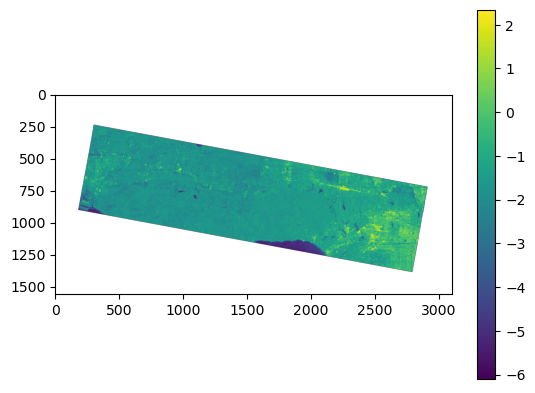

In [19]:
plt.imshow(pre_vv_c[-1])
plt.colorbar()

In [20]:
dist_ob = compute_transformer_zscore(
    transformer,
    pre_vv_c,
    pre_vh_c,
    post_vv_c,
    post_vh_c,
    stride=2,
    agg="max",
    batch_size=256,
    memory_strategy="high",
)

Chips Traversed:   0%| | 0/4660 [00:00<?, ?it/

/Users/cmarshak/miniforge3/envs/distmetrics/lib/python3.13/site-packages/torch/nn/functional.py:5561: UserWarning: The operator 'aten::col2im' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1746257056484/work/aten/src/ATen/mps/MPSFallback.mm:14.)
  return torch._C._nn.col2im(
/Users/cmarshak/bekaert-team/distmetrics/src/distmetrics/tf_metric.py:76: UserWarning: A custom validator is returning a value other than `self`.
Returning anything other than `self` from a top level model validator isn't supported when validating via `__init__`.
See the `model_validator` docs (https://docs.pydantic.dev/latest/concepts/validators/#model-validators) for more details.
  m_dist = DiagMahalanobisDistance2d(dist=z_score, mean=mu, std=sigma)


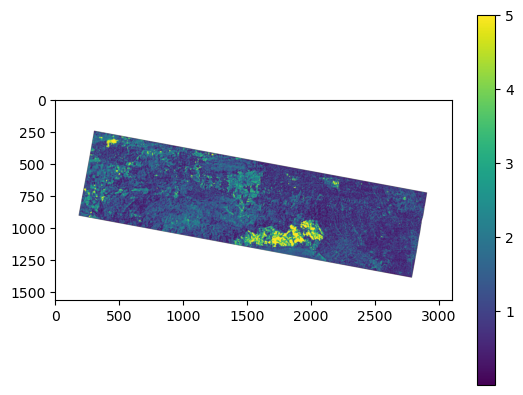

In [21]:
plt.imshow(dist_ob.dist, vmax=5)
plt.colorbar()

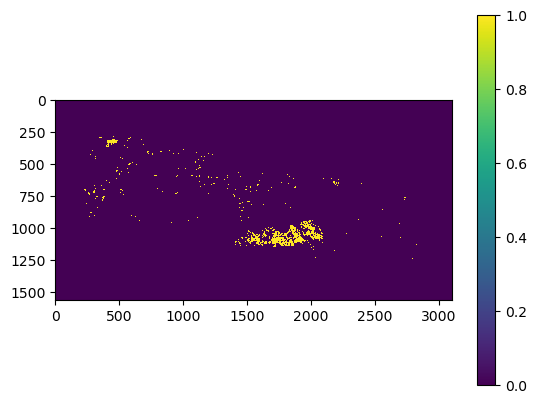

In [22]:
plt.imshow(dist_ob.dist > 3.5, vmax=1, interpolation="none")
plt.colorbar()

**Warninig**: the stat outputs of the function above are in `logits` NOT `gamma naught`. Hence `expit`!

<>:3: SyntaxWarning: invalid escape sequence '\g'
<>:3: SyntaxWarning: invalid escape sequence '\g'
/var/folders/0p/d5x2m4tx5kg1246bplsvyfyh0000gq/T/ipykernel_86194/3498562707.py:3: SyntaxWarning: invalid escape sequence '\g'
  plt.title("Mean Estimate VV ($\gamma$)")


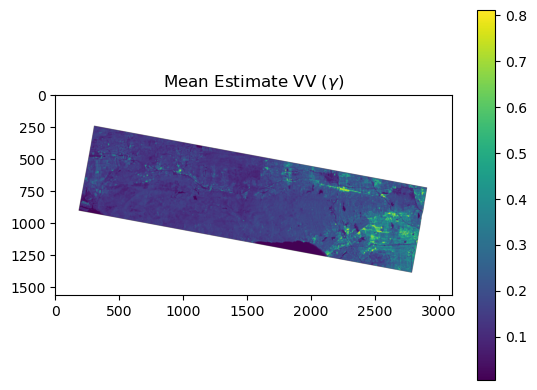

In [23]:
from scipy.special import expit

plt.title("Mean Estimate VV ($\gamma$)")
plt.imshow(expit(dist_ob.mean[0, ...]))
plt.colorbar()

Can't really apply `expit` to `sigma`...

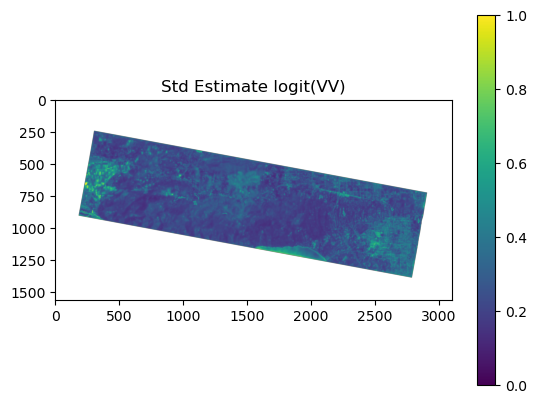

In [24]:
plt.title("Std Estimate logit(VV)")
plt.imshow(dist_ob.std[0, ...], vmax=1, vmin=0)
plt.colorbar()